![](img/575_banner.png)

# Lecture 5: Topic Modeling

UBC Master of Data Science program, 2021-22

Instructor: Varada Kolhatkar

## Lecture plan, imports, LO

### Lecture plan 

- Activity and motivation (~10 mins)
- Introduction and intuition (~15 mins)
- LDA (~15 mins)
- Break (~5 mins)
- iClicker and Q&A (~5 mins)
- Topic modeling with Python (~15 mins)
- Selecting number of topics (~5 mins)
- Final comments and summary (~2 mins)

<br><br>

### Imports

In [1]:
import os.path
import re
import string

import sys
sys.path.append("code/.")
from utils import *

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

from gensim import corpora, matutils, models

pd.set_option("display.max_colwidth", 200)

In [2]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

<br><br>

### Learning outcomes

From this lesson you will be able to

- Explain the general idea of topic modeling.
- Name the two main approaches for topic modeling. 
- Explain the difference between document clustering and topic modeling.  
- Broadly explain the difference between LSA and LDA.
- Broadly explain the data generation process given an LDA topic model.  
- Explain at a high level how topic assignments are updated in the LDA model. 
- Explain the importance of preprocessing in topic modeling. 
- Carry out topic modeling by training an [LDA model with gensim](https://radimrehurek.com/gensim/models/ldamodel.html). 
- Visualize topics identified by topic modeling using `pyLDAvis`. 
- Interpret the output of topic modeling. 
- Name a few possible ways to evaluate a topic model. 
- Explore coherence scores to pick the number of topics.

<br><br><br><br>

## Topic modeling motivation

### Topic modeling introduction activity (~5 mins)

- Consider the following documents. 

In [3]:
toy_clustering = pd.read_csv("data/toy_clustering.csv")
toy_clustering

,text
0,famous fashion model
1,elegant fashion model
2,fashion model at famous probabilistic topic model conference
3,fresh elegant fashion model
4,famous elegant fashion model
5,probabilistic conference
6,creative probabilistic model
7,model diet apple kiwi nutrition
8,probabilistic model
9,kiwi health nutrition


**Discuss the following questions with your neighbour and write your answers in this [Google doc]( 
https://docs.google.com/document/d/1iEZyA6YkcsSNLbmCnuZLUfyF8EBqPC4YE_R8lkXOdpM/edit?usp=sharing
)**. 
1. Suppose you are asked to cluster these documents manually. How many clusters would you identify?
2. What would be the prominent words in each cluster?
3. Which words would occur in more than one cluster? 
4. Do we have to have only one cluster assignment per document? Are there documents which are a mixture of multiple clusters? 

### Why topic modeling? 

- Suppose you have a large collection of documents on a variety of topics. 

### Example: A corpus of news articles 

![](img/TM_NYT_articles.png)

<!-- <center> -->
<!-- <img src="img/TM_NYT_articles.png" height="2000" width="2000">  -->
<!-- </center> -->

### Example: A corpus of food magazines 

![](img/TM_food_magazines.png)

<!-- <center> -->
<!-- <img src="img/TM_food_magazines.png" height="2000" width="2000">  -->
<!-- </center> -->

### A corpus of scientific articles

![](img/TM_science_articles.png)

<!-- <img src="img/TM_science_articles.png" height="2000" width="2000">  -->

(Credit: [Dave Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf))

### Topic modeling motivation

- Humans are pretty good at reading and understanding a document and answering questions such as 
    - What is it about?  
    - Which documents is it related to?     
- But for a large collection of documents it would take years to read all documents and organize and categorize them so that they are easy to search.
- You need an automated way
    - to get an idea of what's going on in the data or 
    - to pull documents related to a certain topic

### Topic modeling

- Topic modeling gives you an ability to summarize the major themes in a large collection of documents (corpus). 
    - Example: The major themes in a collection of news articles could be 
        - **politics**
        - **entertainment**
        - **sports**
        - **technology**
        - ...

- Topic modeling is a great EDA tool to get a sense of what's going on in a large corpus. 
- Some examples
    - If you want to pull documents related to a particular lawsuit. 
    - You want to examine people's sentiment towards a particular candidate and/or political party and so you want to pull tweets or Facebook posts related to election.   

### Topic modeling examples

### Topic modeling: Input 

![](img/TM_science_articles.png)

<!-- <center> -->
<!-- <img src="img/TM_science_articles.png" height="2000" width="2000">  -->
<!-- </center>     -->
    
Credit: [David Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf)

### Topic modeling: output

![](img/TM_topics.png)

<!-- <center> -->
<!-- <img src="img/TM_topics.png" height="900" width="900">  -->
<!-- </center>     -->


(Credit: [David Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf))

### Topic modeling: output with interpretation
- Assigning labels is a human thing. 

![](img/TM_topics_with_labels.png)

<!-- <center> -->
<!-- <img src="img/TM_topics_with_labels.png" height="800" width="800">  -->
<!-- </center>     -->

(Credit: [David Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf))

### LDA topics in Yale Law Journal

![](img/TM_yale_law_journal.png)

<!-- <center> -->
<!-- <img src="img/TM_yale_law_journal.png" height="1500" width="1500">  -->
<!-- </center>     -->

(Credit: [David Blei's paper](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf))

### LDA topics in social media

![](img/TM_health_topics_social_media.png)

<!-- <center> -->
<!-- <img src="img/TM_health_topics_social_media.png" height="1300" width="1300">  -->
<!-- </center> -->

(Credit: [Health topics in social media](https://journals.plos.org/plosone/article/figure?id=10.1371/journal.pone.0103408.g002))

<br><br><br><br>

## Intuition and introduction 

### Topic modeling: Input and output

- Input
    - A large collection of documents
    - A value for the hyperparameter $K$ (e.g., $K = 3$)
- Output
    1. Topic-words association 
        - For each topic, what words describe that topic? 
    2. Document-topics association
        - For each document, what topics are expressed by the document? 
    

### Topic modeling: Example

- Topic-words association 
    - For each topic, what words describe that topic?  
    - **A topic is a mixture of words.** 

![](img/topic_modeling_word_topics.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_word_topics.png" height="1000" width="1000">  -->
<!-- </center>     -->

### Topic modeling: Example

- Document-topics association 
    - For each document, what topics are expressed by the document?
    - **A document is a mixture of topics.** 
    
![](img/topic_modeling_doc_topics.png)

<!-- <center>     -->
<!-- <img src="img/topic_modeling_doc_topics.png" height="800" width="800">  -->
<!-- </center>     -->

### Topic modeling: Input and output

- Input
    - A large collection of documents
    - A value for the hyperparameter $K$ (e.g., $K = 3$)
- Output
    - For each topic, what words describe that topic?  
    - For each document, what topics are expressed by the document?

![](img/topic_modeling_output.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_output.png" height="1000" width="1000">  -->
<!-- </center>     -->

### How do you do topic modeling? 

- A common tool to solve such problems is unsupervised ML methods.
- Given the hyperparameter $K$, the idea of topic modeling is to describe a set of documents using $K$ "topics"
- Two main approaches 
    - Topic modeling as matrix factorization (LSA)
    - Latent Dirichlet Allocation (LDA) 

### Topic modeling as matrix factorization

- We have seen this before in DSCI 563! 
- You can think of topic modeling as a matrix factorization problem. 

$$X_{n \times d} \approx Z_{n \times k}W_{k \times d}$$

- Where 
    - $n \rightarrow $ Number of documents
    - $k \rightarrow $ Number of topics
    - $d \rightarrow $ Number of features (e.g., the size of vocabulary)

- $Z$ gives us document-topic assignments and $W$ gives us topic-word assignments.    
- This is LSA and we used [`TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) for this matrix factorization in `sklearn` 
- The idea is to reduce the dimensionality of the data to some semantically meaningful components. 

### Topic modeling toy example

In [4]:
toy_df = pd.read_csv("data/toy_clustering.csv")
toy_df

,text
0,famous fashion model
1,elegant fashion model
2,fashion model at famous probabilistic topic model conference
3,fresh elegant fashion model
4,famous elegant fashion model
5,probabilistic conference
6,creative probabilistic model
7,model diet apple kiwi nutrition
8,probabilistic model
9,kiwi health nutrition


Let's get BOW representation of the documents. 

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english")
bow = cv.fit_transform(toy_df["text"]).toarray()
bow_df = pd.DataFrame(bow, columns=cv.get_feature_names_out(), index=toy_df["text"])
bow_df

,apple,conference,creative,diet,elegant,famous,fashion,fresh,health,juice,kiwi,model,nutrition,probabilistic,topi,topic
text,,,,,,,,,,,,,,,,
famous fashion model,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
elegant fashion model,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
fashion model at famous probabilistic topic model conference,0,1,0,0,0,1,1,0,0,0,0,2,0,1,0,1
fresh elegant fashion model,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0
famous elegant fashion model,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0
probabilistic conference,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
creative probabilistic model,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
model diet apple kiwi nutrition,1,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0
probabilistic model,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


- Can we extract these **latent features**, which are there in the data but haven't manifested yet? 

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lsa_pipe = make_pipeline(
    CountVectorizer(stop_words="english"), TruncatedSVD(n_components=3)
)

lsa_transformed = lsa_pipe.fit_transform(toy_df["text"]);

In [7]:
pd.DataFrame(
    np.round(lsa_transformed, 4),
    columns=["latent topic 1 ", "latent topic 2", "latent topic 3"],
    index=toy_df["text"],
)

,latent topic 1,latent topic 2,latent topic 3
text,,,
famous fashion model,1.3395,-0.1852,0.7211
elegant fashion model,1.2732,-0.1242,0.9512
fashion model at famous probabilistic topic model conference,2.8280,-0.5133,-0.3490
fresh elegant fashion model,1.3594,0.1891,1.0901
famous elegant fashion model,1.5187,-0.1957,1.1627
probabilistic conference,0.5673,-0.2133,-0.8913
creative probabilistic model,1.1405,-0.1919,-0.6450
model diet apple kiwi nutrition,1.0110,1.6361,-0.1893
probabilistic model,1.0913,-0.1766,-0.5561


- Latent topic 2 seems to be dominant in the fruit-related documents. 
- Latent topic 1 seems to be dominant in model-related documents. 

Let's examine the components learned by LSA. 
- How much variance is covered by these two components? 

In [8]:
lsa_pipe.named_steps["truncatedsvd"].explained_variance_ratio_.sum()

0.6388605814592865

Good to know! 

- Our features are word counts. 
- Which features have higher weights in latent topic 1 vs. latent topic 2? 

You can print these words in a nice format using `mglearn.tools.print_topics`. 

In [11]:
sorting = np.argsort(lsa_pipe.named_steps["truncatedsvd"].components_, axis=1)[:, ::-1]

feature_names = np.array(
    lsa_pipe.named_steps["countvectorizer"].get_feature_names_out()
)
print_topics(
    topics=[0, 1, 2], feature_names=feature_names, sorting=sorting, n_words=5
)

topic 0       topic 1       topic 2       
--------      --------      --------      
model         kiwi          fashion       
fashion       nutrition     elegant       
probabilistic apple         famous        
famous        fresh         fresh         
conference    health        model         




- LSA has learned three useful "concepts" or latent features from word count features. 

<br><br>

### Alternative: Latent Dirichlet Allocation (LDA)

- A Bayesian, probabilistic, and generative approach  
- Developed by [David Blei](http://www.cs.columbia.edu/~blei/) and colleagues in 2003. 
    * One of the most cited papers in the last 20 years.
- DISCLAIMER    
    - We won't go into the math because we do not have the time. 
    - My goal is to give you an intuition of the model and show you how to use it to solve topic modeling problems. 

### LDA high-level idea

- Dirichlet distribution is a distribution of distributions. 
- In our case,
    - Every document is a discrete probability distribution of topics. 
    - Every topic is a discrete probability distribution of words.
    - So we are have distributions of distributions.     

### LDA: insight
- Each document is a mixture of corpus-wide topics
- Every topic is a mixture words

![](img/TM_dist_topics_words_blei.png)

<!-- <center> -->
<!-- <img src="img/TM_dist_topics_words_blei.png" height="1000" width="1000">  -->
<!-- </center>     -->

(Credit: [David Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf))

<br><br><br><br>

## High-level intuition of LDA

Attribution: Material and presentation in the next slides is adapted from [Jordan Boyd-Graber's excellent material on LDA](http://users.umiacs.umd.edu/~jbg/teaching/CMSC_726/16a.pdf).


- Generative, Bayesian, probabilistic model

### Generative story of LDA
- The story that tells us how our data was generated. 
- The generative story of LDA to create Document 1 below:     
    1. Pick a topic from the topic distribution for Document 1. 
    2. Pick a word from the selected topic's word distribution. 
- Not a realistic story but a mathematically useful story. 

![](img/topic_modeling_generative_story.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_generative_story.png" height="600" width="600">  -->
<!-- </center>     -->

### Goal 
- Given a corpus of documents and the number of topics we want to learn 
    - the discrete probability distributions over topics for each document
    - the discrete probability distributions over words for each topic


### (Optional) Plate notation

- Used in Bayesian inference for representing variables that repeat. 
- It shows the generative process of the LDA model. It also shows the dependency structure in the probability distribution.
- We are not going into the details but I would like you to be familiar with this picture at a high-level because it's likely that you might see it in the context of topic modeling. 

![](img/topic_modeling_plate_diagram.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_plate_diagram.png" height="500" width="500">  -->
<!-- </center>     -->

- $\beta_k \rightarrow$ Distribution over words for topic $k$
- $\theta_d \rightarrow$ Distribution over topics for document $d$ 
- $w_n \rightarrow$ word
- $Z_n \rightarrow$ topic
- $N \rightarrow$ Size of the vocabulary
- $M \rightarrow$ Number of documents
- $\lambda \rightarrow$ Hyperparameter for word proportion
- $\alpha\rightarrow$ Hyperparameter for topic proportion  

### (Optional) Mathematical presentation of the generative story (plate diagram)

![](img/topic_modeling_plate_diagram.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_plate_diagram.png" height="500" width="500">  -->
<!-- </center>     -->


- For each topic $k \in \{1, \dots, K\}$ draw a multinomial distribution $\beta_k$ from a Dirichlet distribution with parameter $\lambda$. 
- For each document $d \in \{1, \dots, M\}$, draw a multinomial distribution $\theta_d$
from a Dirichlet distribution with parameter $\alpha$. 
- For each word position $n \in \{1, \dots, N\}$, select a hidden topic $Z_n$ from the multinomial distribution parameterized by $\theta$.
- Choose the observed word $w_n$ from the distribution $\beta_{Z_n}$. 

[Source](http://users.umiacs.umd.edu/~jbg/teaching/CMSC_726/16a.pdf)

### (Optional) LDA Inference

- Infer the underlying topic structure in the documents. In particular, 
    - Learn the discrete probability distributions of topics in each document
    - Learn the discrete probability distributions of words in each topic

### (Optional) LDA Inference

- We are interested in the posterior distribution: $P(z, \beta, \theta| w_n, \alpha, \lambda)$
- Observations: words. Everything else is hidden (latent). 

![](img/topic_modeling_plate_diagram.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_plate_diagram.png" height="600" width="600">  -->
<!-- </center>     -->


- $\lambda$: Hyperparameter for word proportion
    - High $\lambda$ &rarr; every topic contains a mixture of most of the words
    - Low $\lambda$ &rarr; every topic contains a mixture of only few words
    
- $\alpha$: Hyperparameter for topic proportion  
   - High $\alpha$ &rarr; every document contains a mixture of most of the topics
   - Low $\alpha$ &rarr; every document is representative of only a few topics    

### How do we find the posterior distribution? 

- We are interested in the posterior distribution of document topic assignments and word topic assignments. 
- How do we find it? 
    - **Gibbs sampling** (very accurate but very slow, appropriate for small datasets)
    - Variational inference (faster but less accurate, extension of expectation maximization, appropriate for medium to large datasets)    
    
- Next let's look at an intuition of Gibbs sampling for topic modeling. 

### LDA algorithm: Gibbs sampling 

- Sample topic assignments
- Calculate conditional probability of single word topic assignment conditioned on the rest of the parameters. s 
- Two components
    - How much this document likes the topic
    - How much this topic likes the word

![](img/topic_modeling_topic_word_assignment.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_topic_word_assignment.png" height="700" width="700">  -->
<!-- </center>     -->

### (Optional) Gibbs sampling equation: Calculating the conditional probability

- Sets up a Markov chain that converges into the posterior distribution of the model parameters or word–topic assignments.
- Two components
    - How much this document likes topic $k$: 
    $$\frac{n_{d,k} + \alpha_k}{\sum^K_i n_{d,i} + \alpha_i}$$
    - How much this topic likes word $w_{d,n}$: $$\frac{V_{k, w_{d,n}} + \lambda_{w_{d,n}}}{\sum_i V_{k,i} + \lambda_i}$$ 
- The conditional probability of word topic assignment given everything else in the model: 

$$\frac{n_{d,k} + \alpha_k}{\sum^K_i n_{d,i} + \alpha_i} \frac{V_{k, w_{d,n}} + \lambda_{w_{d,n}}}{\sum_i V_{k,i} + \lambda_i}$$

- $n_{d,k} \rightarrow$ number of times document $d$ uses topic $k$ 
- $V_{k, w_{d,n}} \rightarrow$ number of times topic $k$ uses word type $w_{d,n}$
- $\alpha_k \rightarrow$ Dirichlet parameter for document to topic distribution
- $\lambda_{w_{d,n}} \rightarrow$ Dirichlet parameter for topic to word distribution

### (Optional) LDA algorithm 

- Suppose $K$ is number of topics
- For each iteration $i$
    - For each document $d$ and word $n$ currently assigned to topic $Z_{old}$
        - Decrement $n_{d,Z_{old}}$ and $V_{Z_{old}, w_{d,n}}$
        - Sample $Z_{new} = k$ with probability proportional to $\frac{n_{d,k} + \alpha_k}{\sum^K_i n_{d,i} + \alpha_i} \frac{V_{k, w_{d,n}} + \lambda_{w_{d,n}}}{\sum_i V_{k,i} + \lambda_i}$
        - Increment $n_{d, Z_{new}} and V_{Z_{new}, w_{d,n}}$
    

### LDA algorithm example

#### Random topic assignment

- Randomly assign each word in each document to one of the topics. 
    - The same word in the vocabulary may have different topic assignments in different instances.  

#### Sample document and random topic assignment
- Consider this sample document (Document 10) with random topic assignment

![](img/topic_modeling_word_topic_assignment.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_word_topic_assignment.png" height="800" width="800">  -->
<!-- </center>     -->


- With the current topic assignment, here are the topic counts in our document 

![](img/topic_modeling_doc_topic_counts.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_doc_topic_counts.png" height="700" width="700">  -->
<!-- </center>     -->


#### Total topic counts

- Find out how much each word in the document is liked by each topic.
- For each word in our current document (Document 10), calculate how often that word occurs with each topic in all documents

![](img/topic_modeling_word_topic_counts.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_word_topic_counts.png" height="700" width="700">  -->
<!-- </center>     -->


We want to figure out a way to revise word-topic assignments. For that we sample a word-topic assignment and revise it assuming that we know everything else in the model.

#### Sample a word-topic assignment

- Suppose our sampled word-topic assignment is the word _probabilistic_ in Document 10 with assigned topic 3. 
- How often does the Topic 3 occur in Document 10? Once. 
- How often does the word _probabilistic_ occur with Topic 3 in the corpus? Twice.  

<!-- <center> -->
![](img/topic_modeling_word_topic_assignment.png)
<!-- <img src="img/topic_modeling_word_topic_assignment.png" height="600" width="600">  -->

![](img/topic_modeling_doc_topic_counts.png)
<!-- <img src="img/topic_modeling_doc_topic_counts.png" height="600" width="600">  -->

![](img/topic_modeling_word_topic_counts.png)
<!-- <img src="img/topic_modeling_word_topic_counts.png" height="600" width="600">  -->
<!-- </center>     -->


#### Decrement counts

- We want to update the word topic assignment of _probabilistic_ and Topic 3. 
- Decrement the count of the word from the word-topic counts.

![](img/topic_modeling_count_decrement.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_count_decrement.png" height="1200" width="1200">  -->
<!-- </center> -->

#### Calculating conditional probability distribution 

- How much does Document 10 like each topic?
- How much does each topic like word _probabilistic_ ? 

<!-- <center> -->
![](img/topic_modeling_decremented_counts.png)
<!-- <img src="img/topic_modeling_decremented_counts.png" height="500" width="500">  -->

![](img/topic_modeling_conditional_proba.png)
<!-- <img src="img/topic_modeling_conditional_proba.png" height="800" width="800"> -->
<!-- </center>     -->


#### Updating topic assignment

- So update the topic of the current word _probabilistic_ in document 10 to **topic 1**
- Update the document-topic and word-topic counts accordingly. 

![](img/topic_modeling_update_count.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_update_count.png" height="1200" width="1200">  -->
<!-- </center> -->

#### Conclusion

- In one pass, the algorithm repeats the above steps for each word in the corpus
- If you do this for several passes, meaningful topics emerge. 

<br><br><br><br>

![](img/eva-coffee.png)

<br><br><br><br>

## ❓❓ Questions for you

iClicker cloud join link: https://join.iclicker.com/4QVT4

### Exercise 5.1: Select all of the following statements which are **True** (iClicker)

- (A) Latent Dirichlet Allocation (LDA) is an unsupervised approach. 
- (B) The assumption in topic modeling is that different topics tend to use different words. 
- (C) We could use LSA for topic modeling, where $Z$ gives us the mixture of topics per document. 
- (D) In LDA topic model, a document is a mixture of multiple topics. 
- (E) If I train a topic model on a large collection of news articles with K = 10, I would get 10 topic labels (e.g., sports, culture, politics, finance) as output. 

<br><br><br><br>

```{admonition} Exercise 5.1: V's Solutions!
:class: tip, dropdown
- (A) 
- (B) 
- (C) 
- (D) 
- (E) 
```

### Exercise 5.2: Questions for class discussion 

1. What's the difference between topic modeling and document clustering using algorithms such as K-Means clustering? 
2. In 563 lab1, we carried out document clustering using K-Means and sentence embedding representation of documents. Would it be a good idea to use sentence embedding representation of documents to a topic model? 
3. Imagine that you are using LSA for topic modeling, where $X$ is bag-of-words representation of $N$ documents and $V$ features (number of words in the vocabulary). Explain which matrix would give you word distribution over topics and which matrix would give you topic distribution over documents.
$$X_{N \times V} = Z_{N \times K} W_{K \times V}$$



```{admonition} Exercise 5.2: V's Solutions!
:class: tip, dropdown
1.
2.
3.

```

<br><br><br><br>

## Topic modeling with Python

- `scikit-learn` has implementation of LDA but we'll be using another library called [gensim](https://radimrehurek.com/gensim/models/ldamodel.html), which we used for `Word2Vec`, because it's more flexible.   


### Topic modeling pipeline 

- Preprocess your corpus. 
- Train LDA using `Gensim`.
- Interpret your topics.     

### Data

Let's work with a slightly bigger corpus. We'll extract text from a few Wikipedia articles and apply topic modeling on these texts. 

In [12]:
import wikipedia

queries = [
    "Artificial Intelligence",
    "Supervised Machine Learning",
    "Supreme Court of Canada",
    "Peace, Order, and Good Government",
    "Canadian constitutional law",
    "ice hockey",
    "Google company",
    "Google litigation",
]
wiki_dict = {"wiki query": [], "text": []}
for i in range(len(queries)):
    text = wikipedia.page(queries[i]).content
    wiki_dict["text"].append(text)
    print(len(text))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

54862
26059
21609
15856
16999
73034
54448
19035


,wiki query,text
0,Artificial Intelligence,"Artificial intelligence (AI) is intelligence—perceiving, synthesizing, and inferring information—demonstrated by machines, as opposed to intelligence displayed by non-human animals and humans. Exa..."
1,Supervised Machine Learning,"Supervised learning (SL) is a machine learning paradigm for problems where the available data consists of labeled examples, meaning that each data point contains features (covariates) and an assoc..."
2,Supreme Court of Canada,"The Supreme Court of Canada (SCC; French: Cour suprême du Canada, CSC) is the highest court in the judicial system of Canada. It comprises nine justices, whose decisions are the ultimate applicati..."
3,"Peace, Order, and Good Government","In many Commonwealth jurisdictions, the phrase ""peace, order, and good government"" (POGG) is an expression used in law to express the legitimate objects of legislative powers conferred by statute...."
4,Canadian constitutional law,Canadian constitutional law (French: droit constitutionnel du Canada) is the area of Canadian law relating to the interpretation and application of the Constitution of Canada by the courts. All la...
5,ice hockey,"Ice hockey (or simply hockey) is a team sport played on ice skates, usually on an ice skating rink with lines and markings specific to the sport. It belongs to a family of sports called hockey. In..."
6,Google company,"Google LLC ( (listen)) is an American multinational technology company focusing on online advertising, search engine technology, cloud computing, computer software, quantum computing, e-commerce, ..."
7,Google litigation,"Google has been involved in multiple lawsuits over issues such as privacy, advertising, intellectual property and various Google services such as Google Books and YouTube. The company's legal depa..."


### Preprocessing the corpus 

- **Preprocessing is crucial!**
- Tokenization, converting text to lower case
- Removing punctuation and stopwords
- Discarding words with length < threshold or word frequency < threshold        
- Possibly lemmatization: Consider the lemmas instead of inflected forms. 
- Depending upon your application, restrict to specific part of speech;
    * For example, only consider nouns, verbs, and adjectives
    
We'll use [`spaCy`](https://spacy.io/) for preprocessing. 

In [13]:
# !python -m spacy download en_core_web_md

In [14]:
import spacy

nlp = spacy.load("en_core_web_md")

In [15]:
def preprocess_spacy(
    doc,
    min_token_len=2,
    irrelevant_pos=["ADV", "PRON", "CCONJ", "PUNCT", "PART", "DET", "ADP"],
):
    """
    Given text, min_token_len, and irrelevant_pos carry out preprocessing of the text
    and return a preprocessed string.

    Parameters
    -------------
    doc : (spaCy doc object)
        the spacy doc object of the text
    min_token_len : (int)
        min_token_length required
    irrelevant_pos : (list)
        a list of irrelevant pos tags

    Returns
    -------------
    (str) the preprocessed text
    """

    clean_text = []

    for token in doc:
        if (
            token.is_stop == False  # Check if it's not a stopword
            and len(token) > min_token_len  # Check if the word meets minimum threshold
            and token.pos_ not in irrelevant_pos
        ):  # Check if the POS is in the acceptable POS tags
            lemma = token.lemma_  # Take the lemma of the word
            clean_text.append(lemma.lower())
    return " ".join(clean_text)

In [16]:
wiki_df["text_pp"] = [preprocess_spacy(text) for text in nlp.pipe(wiki_df["text"])]

In [17]:
wiki_df

,wiki query,text,text_pp
0,Artificial Intelligence,"Artificial intelligence (AI) is intelligence—perceiving, synthesizing, and inferring information—demonstrated by machines, as opposed to intelligence displayed by non-human animals and humans. Exa...",artificial intelligence intelligence perceive synthesizing infer information demonstrate machine oppose intelligence display non human animal human example task include speech recognition computer...
1,Supervised Machine Learning,"Supervised learning (SL) is a machine learning paradigm for problems where the available data consists of labeled examples, meaning that each data point contains features (covariates) and an assoc...",supervised learning machine learn paradigm problem available datum consist label example mean datum point contain feature covariate associated label goal supervised learning algorithm learn functi...
2,Supreme Court of Canada,"The Supreme Court of Canada (SCC; French: Cour suprême du Canada, CSC) is the highest court in the judicial system of Canada. It comprises nine justices, whose decisions are the ultimate applicati...",supreme court canada scc french cour suprême canada csc high court judicial system canada comprise justice decision ultimate application canadian law grant permission litigant year appeal decision...
3,"Peace, Order, and Good Government","In many Commonwealth jurisdictions, the phrase ""peace, order, and good government"" (POGG) is an expression used in law to express the legitimate objects of legislative powers conferred by statute....",commonwealth jurisdiction phrase peace order good government pogg expression law express legitimate object legislative power confer statute phrase appear imperial acts parliament letters patent co...
4,Canadian constitutional law,Canadian constitutional law (French: droit constitutionnel du Canada) is the area of Canadian law relating to the interpretation and application of the Constitution of Canada by the courts. All la...,canadian constitutional law french droit constitutionnel canada area canadian law relate interpretation application constitution canada court law canada provincial federal conform constitution law...
5,ice hockey,"Ice hockey (or simply hockey) is a team sport played on ice skates, usually on an ice skating rink with lines and markings specific to the sport. It belongs to a family of sports called hockey. In...",ice hockey hockey team sport play ice skate ice skating rink line marking specific sport belong family sport call hockey ice hockey oppose team use ice hockey stick control advance shoot closed vu...
6,Google company,"Google LLC ( (listen)) is an American multinational technology company focusing on online advertising, search engine technology, cloud computing, computer software, quantum computing, e-commerce, ...",google llc listen american multinational technology company focus online advertising search engine technology cloud computing computer software quantum computing commerce artificial intelligence c...
7,Google litigation,"Google has been involved in multiple lawsuits over issues such as privacy, advertising, intellectual property and various Google services such as Google Books and YouTube. The company's legal depa...",google involve multiple lawsuit issue privacy advertising intellectual property google service google books youtube company legal department expand 100 lawyer year business 2014 grow 400 lawyer go...


### Training LDA with [gensim](https://radimrehurek.com/gensim/models/ldamodel.html)

To train an LDA model with [gensim](https://radimrehurek.com/gensim/models/ldamodel.html), you need

- Document-term matrix 
- Dictionary (vocabulary)
- The number of topics ($K$): `num_topics`
- The number of passes: `passes`

### `Gensim`'s `doc2bow`
- Let's first create a dictionary using [`corpora.Dictionary`](https://radimrehurek.com/gensim/corpora/dictionary.html). 

In [18]:
corpus = [doc.split() for doc in wiki_df["text_pp"].tolist()]
dictionary = corpora.Dictionary(corpus)  # Create a vocabulary for the lda model
pd.DataFrame(
    dictionary.token2id.keys(), index=dictionary.token2id.values(), columns=["Word"]
)

,Word
0,1.6
1,"134,777"
2,"167,038"
3,1863
4,1943
...,...
4914,wilberg
4915,window
4916,windows
4917,wiretap


### `Gensim`'s `doc2bow`
- Now let's convert our corpus into document-term matrix for LDA using [`dictionary.doc2bow`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow).
- For each document, it stores the frequency of each token in the document in the format (token_id, frequency). 

In [19]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
doc_term_matrix[1][:20]

[(57, 4),
 (68, 3),
 (74, 1),
 (80, 3),
 (88, 1),
 (89, 3),
 (114, 53),
 (123, 1),
 (132, 4),
 (133, 1),
 (134, 1),
 (146, 1),
 (147, 1),
 (148, 4),
 (149, 3),
 (164, 1),
 (166, 1),
 (174, 2),
 (182, 2),
 (192, 4)]

Now we are ready to train an LDA model. 

In [20]:
from gensim.models import LdaModel

num_topics = 4

lda = models.LdaModel(
    corpus=doc_term_matrix,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
)

### Examine the topics and topic distribution for a document in our LDA model

In [21]:
lda.print_topics(num_words=4)  # Topics

[(0,
  '0.009*"algorithm" + 0.009*"intelligence" + 0.008*"learning" + 0.008*"\\displaystyle"'),
 (1, '0.001*"google" + 0.000*"hockey" + 0.000*"ice" + 0.000*"court"'),
 (2, '0.063*"google" + 0.011*"company" + 0.010*"search" + 0.005*"billion"'),
 (3, '0.023*"hockey" + 0.015*"court" + 0.014*"ice" + 0.011*"team"')]

In [22]:
print("Document label: ", wiki_df.iloc[7][0])
print("Topic assignment for document: ", lda[doc_term_matrix[7]])  # Topic distribution

Document label:  Google litigation
Topic assignment for document:  [(2, 0.4452362), (3, 0.554476)]


In [23]:
topic_assignment = sorted(lda[doc_term_matrix[7]], key=lambda x: x[1], reverse=True)
df = pd.DataFrame(topic_assignment, columns=["topic id", "probability"])
df

,topic id,probability
0,3,0.554476
1,2,0.445236


In [24]:
new_doc = "After the court yesterday lawyers working on Google lawsuits went to a ice hockey game."
pp_new_doc = preprocess_spacy(nlp(new_doc))
pp_new_doc

'court yesterday lawyer work google lawsuit go ice hockey game'

In [25]:
bow_vector = dictionary.doc2bow(pp_new_doc.split())

In [26]:
topic_assignment = sorted(lda[bow_vector], key=lambda x: x[1], reverse=True)
df = pd.DataFrame(topic_assignment, columns=["topic id", "probability"])
df

,topic id,probability
0,3,0.600286
1,2,0.349240
2,0,0.025438
3,1,0.025035


### Visualize topics

You can also visualize the topics using `pyLDAvis`. 

```
pip install pyLDAvis

```

> Do not install it using `conda`. They have made some changes in the recent version and `conda` build is not available for this version yet. 

In [27]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [28]:
vis = gensimvis.prepare(lda, doc_term_matrix, dictionary, sort_topics=False)
vis

/Users/kvarada/miniconda3/envs/575/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.065967 -0.155230       1        1  30.635659
1     -0.001985 -0.000016       2        1   0.008559
2      0.116158  0.128944       3        1  24.611011
3     -0.180139  0.026301       4        1  44.744771, topic_info=            Term        Freq       Total Category  logprob  loglift
681       google  391.000000  391.000000  Default  30.0000  30.0000
3323      hockey  247.000000  247.000000  Default  29.0000  29.0000
3340         ice  152.000000  152.000000  Default  28.0000  28.0000
1119      player  118.000000  118.000000  Default  27.0000  27.0000
3428      league  112.000000  112.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1137       power   43.707173   69.548156   Topic4  -5.4802   0.3397
1569      united   35.667210   49.509016   Topic4  -5.6834   0.4763
677         goal   35.633161   54.021438   Topic4  -5.6844   0.3881
1649       world   33.636840   52.892696   Topic4  -5.7420   0.3516
2249  provincial   34.104266   59.117441   Topic4  -5.7282   0.2541

[285 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1664      1  0.667398    -\sum
3914      3  0.674960  132,121
3930      3  0.922925     2007
36        1  0.057178     2013
36        3  0.857665     2013
...     ...       ...      ...
1649      4  0.642811    world
1894      1  0.667437     y_{i
1654      1  0.079633     year
1654      3  0.258806     year
1654      4  0.637061     year

[361 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

### (Optional) Topic modeling with `sklearn`

- We are using `Gensim` LDA so that we'll be able to use `CoherenceModel` to evaluate topic model later. 
- Bit we can also train an LDA model with `sklearn`.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(wiki_df["text_pp"])

In [30]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 3
lda = LatentDirichletAllocation(
    n_components=n_topics, learning_method="batch", max_iter=10, random_state=0
)
document_topics = lda.fit_transform(X)

In [31]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (3, 4804)


In [33]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vec.get_feature_names_out())

In [34]:
print_topics(
    topics=range(3),
    feature_names=feature_names,
    sorting=sorting,
    topics_per_chunk=5,
    n_words=10,
)

topic 0       topic 1       topic 2       
--------      --------      --------      
hockey        google        court         
ice           court         intelligence  
team          company       machine       
player        search        artificial    
game          power         problem       
play          displaystyle  human         
league        law           justice       
penalty       government    case          
puck          inc           law           
canada        algorithm     supreme       




<br><br><br><br>

## A few comments on evaluation 

- In topic modeling we would like each topic to have some semantic theme which is interpretable by humans. 
- The idea of a topic model is to tell a story to humans and that's what we should care about and evaluate.

![](img/TM_health_topics_social_media.png)

<!-- <center> -->
<!-- <img src="img/TM_health_topics_social_media.png" height="700" width="700">  -->
<!-- </center> -->

(Credit: [Health topics in social media](https://journals.plos.org/plosone/article/figure?id=10.1371/journal.pone.0103408.g002))

### A few ways to evaluate a topic model

- Eye balling top $n$ words or documents with high probability for each topic. 
- Human judgments
    - Ask humans to evaluate a topic model and whether they are able to tell a coherent story about the collection of documents using the topic model. 
    - Word intrusion 
- Extrinsic evaluation
    - If you are using topic modeling as features in tasks such as sentiment analysis or machine translation, evaluate whether topic model with the current hyperparameters improves the results of that task or not. 
- Capturing topic interpretability
    - Coherence scores    


### Human judgments: Word intrusion

- Word intrusion: Take high probability words from a topic. Now add a high probability word from another topic to this topic. 
- Likely words from old topic
    - dentist, appointment, doctors, tooth
- Likely words from old topic    
    - dentist, **mom**, appointment, doctors, tooth

- Are we able to distinguish this odd word out from the original topic?

### [Coherence model](https://radimrehurek.com/gensim/models/coherencemodel.html)

- Coherence models provide a framework to evaluate the **coherence** of the topic by measuring the degree of semantic similarity between most likely words in the topic. 
- Roughly, high coherence score means the topics are semantically interpretable and low coherence scores means they are not semantically similar. 
- Let's try it out on our toy data. 

In [35]:
# Compute Coherence Score
from gensim.models import CoherenceModel

K = [1, 2, 3, 4, 5, 6]

coherence_scores = []

for num_topics in K:
    lda = models.LdaModel(
        corpus=doc_term_matrix,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
    )
    coherence_model_lda = CoherenceModel(
        model=lda, texts=corpus, dictionary=dictionary, coherence="c_v"
    )
    coherence_scores.append(coherence_model_lda.get_coherence())

In [36]:
df = pd.DataFrame(coherence_scores, index=K, columns=["Coherence score"])
df

,Coherence score
1,0.291770
2,0.376235
3,0.498293
4,0.438114
5,0.566066
6,0.471210


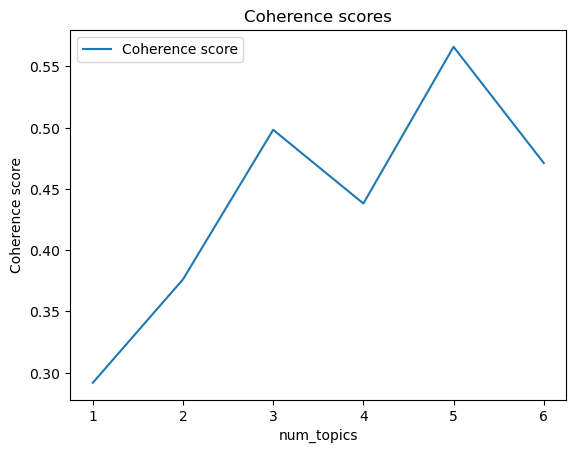

In [37]:
df.plot(title="Coherence scores", xlabel="num_topics", ylabel="Coherence score");

We are getting the best coherence score with `num_topics = 6`. That said, similar to other methods to pick the best hyperparameters in an unsupervised setting, take this with a grain of salt. The model with highest coherence score is not always going to be the best topic model. You need to balance the topic sizes and coherence scores. It's always a good idea to manually examine the topics resulted by the chosen number of topics and examine whether you are able to make sense of these topics or or not before finalizing the number of topics. In the end our goal is to get human interpretable topics, and that's what we should try to focus on.   

In [38]:
df

,Coherence score
1,0.291770
2,0.376235
3,0.498293
4,0.438114
5,0.566066
6,0.471210


<br><br><br><br>

## Final comments and summary

### Important ideas to know

- Topic modeling is a tool to uncover important themes in a large collection of documents.
- The overall goal is to tell a high-level story about a large collection of documents to humans. 

![](img/TM_health_topics_social_media.png)

<!-- <center> -->
<!-- <img src="img/TM_health_topics_social_media.png" height="900" width="900">  -->
<!-- </center> -->

(Credit: [Health topics in social media](https://journals.plos.org/plosone/article/figure?id=10.1371/journal.pone.0103408.g002))

### Important ideas to know

- Latent dirichlet allocation (LDA) is a commonly used model for topic modeling, which is a Bayesian, probabilistic, and generative model. 
- Topic is something that influences the choice of vocabulary of a document. For each document, we assume that several topics are active with varying importance. 
- The primary idea of the model is 
    - A document is a mixture of topics 
    - A topic is a mixture of words in the vocabulary 

### Important ideas to know

- You can carry out topic modeling with LDA in Python using the `Gensim` library. 
- Preprocessing is extremely important in topic modeling. 
- Some of the most common steps in preprocessing for topic modeling include
    - Sentence segmentation, tokenization, lemmatization, stopword and punctuation removal  
- You can visualize topic model using `pyLDAvis`. 

<br><br><br><br>

## Some useful resources and links 
- [LDA with `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
- [Jordan Boyd-Graber's very approachable explanation of LDA](https://www.youtube.com/watch?v=fCmIceNqVog)
- [lda2vec](https://github.com/cemoody/lda2vec)
- [Original topic modeling paper: David Blei et al. 2003](http://www.cs.columbia.edu/~blei/papers/BleiNgJordan2003.pdf)
- [Topic modeling for computational social scientists ](http://topicmodels.info/)
- [spaCy's Python for data science cheat sheet](http://datacamp-community-prod.s3.amazonaws.com/29aa28bf-570a-4965-8f54-d6a541ae4e06)
- If you want to learn more about practical aspects of LDA
    - [Rethinking LDA: Why Priors Matter](https://papers.nips.cc/paper/2009/hash/0d0871f0806eae32d30983b62252da50-Abstract.html)
    - [LDA Revisited: Entropy, Prior and Convergence](https://static.aminer.org/pdf/fa/cikm2016/lfp0616-zhangAemb.pdf)

<br><br><br><br>